In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data
from useful_fun import plot_distribution, percentage_outof_CI, number_outof_CI

In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data, train_test=False)

# train/test split
df_train = pd.read_csv('../../data/train.csv')
x_train, y_train = separate_data(df_train)
df_test = pd.read_csv('../../data/test.csv')
x_test, y_test = separate_data(df_test)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

2022-08-15 23:17:25.264642: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-15 23:17:25.872778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


# Simple one-latent function model

        y = f(x) + e
        f = GP(0, RBF)

        l = InvGama()
        sigma = Gamma()

# Train / Test split: model selection

Assess which kernel helps represent the data best.

    MSE, MAE, Likelihood

Since we have found that the starting point of kernel parameters affects the fit significantly, we will first select the kernel and then run an analysis to find optimal starting conditions for hyperparameters.

In [3]:
def optimise_predict_model(model, epochs=50):
    train_data = (x_train, y_train)
    loss_fn = model.training_loss_closure(train_data) 

    gpflow.utilities.set_trainable(model.q_mu, False)
    gpflow.utilities.set_trainable(model.q_sqrt, False)

    variational_vars = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
    adam_vars = model.trainable_variables
    adam_opt = tf.optimizers.Adam(0.01)

    @tf.function
    def optimisation_step():
        natgrad_opt.minimize(loss_fn, variational_vars)
        adam_opt.minimize(loss_fn, adam_vars)

    for epoch in range(1, epochs + 1):
        optimisation_step()

    # fitted values
    mean_train, var_train = model.predict_y(x_train)
    print('Train')
    plot_distribution(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

    # predict
    mean_test, var_test = model.predict_y(x_test)
    print('Test')
    plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

    print('train ELBO, MSE, MAE: ', model.elbo((x_train,y_train)).numpy(), mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
    print('test ELBO, MSE, MAE: ', model.elbo((x_test,y_test)).numpy(), mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))
    print('percentage out of CI (train, test): ', percentage_outof_CI(y_train, mean_train, var_train), percentage_outof_CI(y_test, mean_test, var_test))
    print('number out of CI (train, test): ', number_outof_CI(y_train, mean_train, var_train), number_outof_CI(y_test, mean_test, var_test))

    print_summary(model, fmt='notebook')

2022-08-15 23:17:32.188279: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-15 23:17:40.039905: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x89f6620


Train


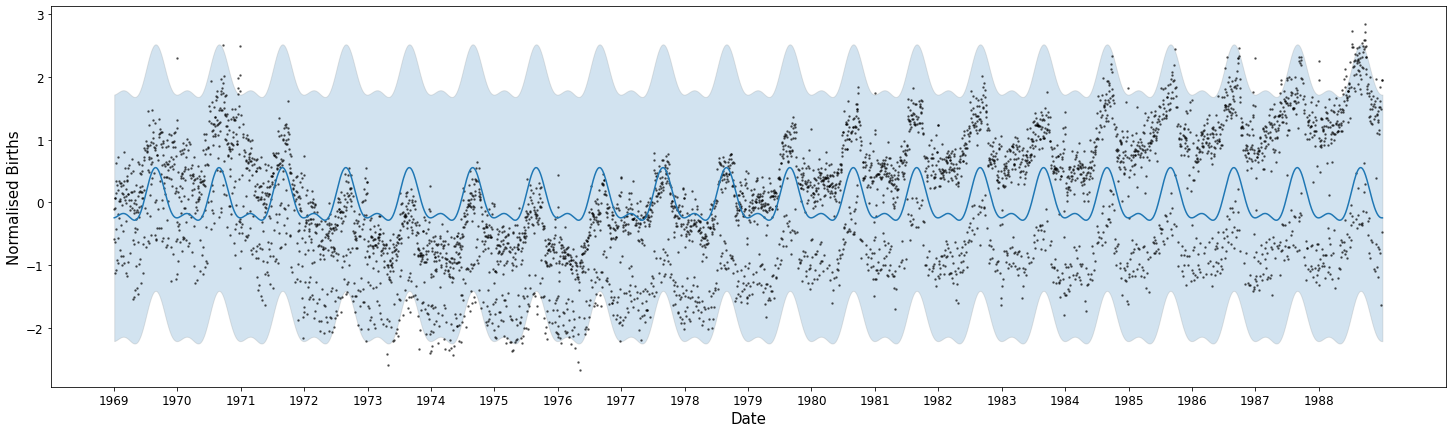

Test


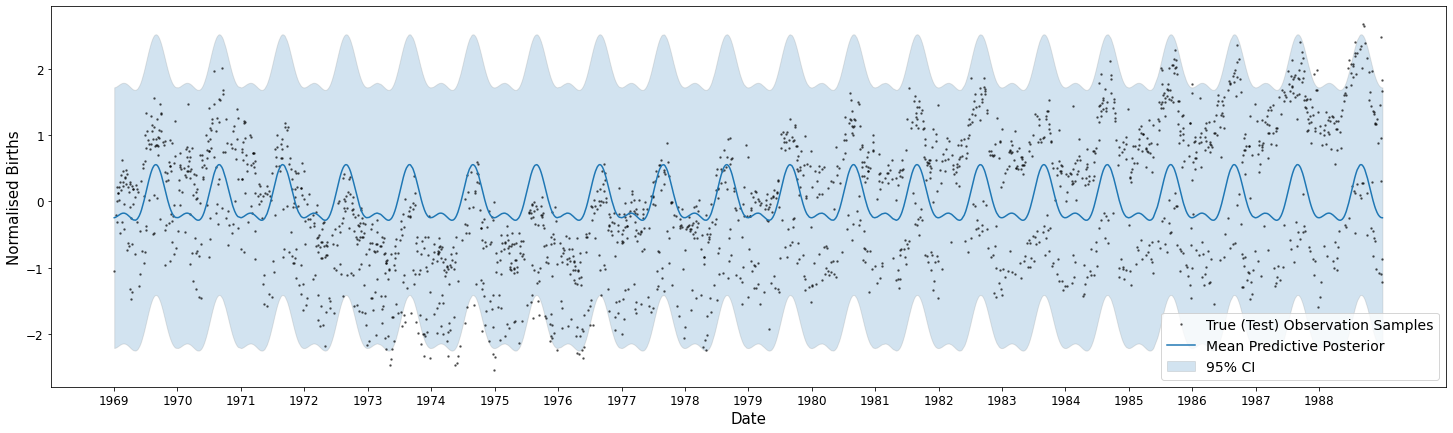

train ELBO, MSE, MAE:  -4143.762683759172 0.9148067232545116 0.8164018487632047
test ELBO, MSE, MAE:  -4165.353049400295 0.9291947601898329 0.8268268056157497
percentage out of CI (train, test):  2.386074711519656 2.144160583941606
number out of CI (train, test):  122 47


--------------------------------------------------------
Train


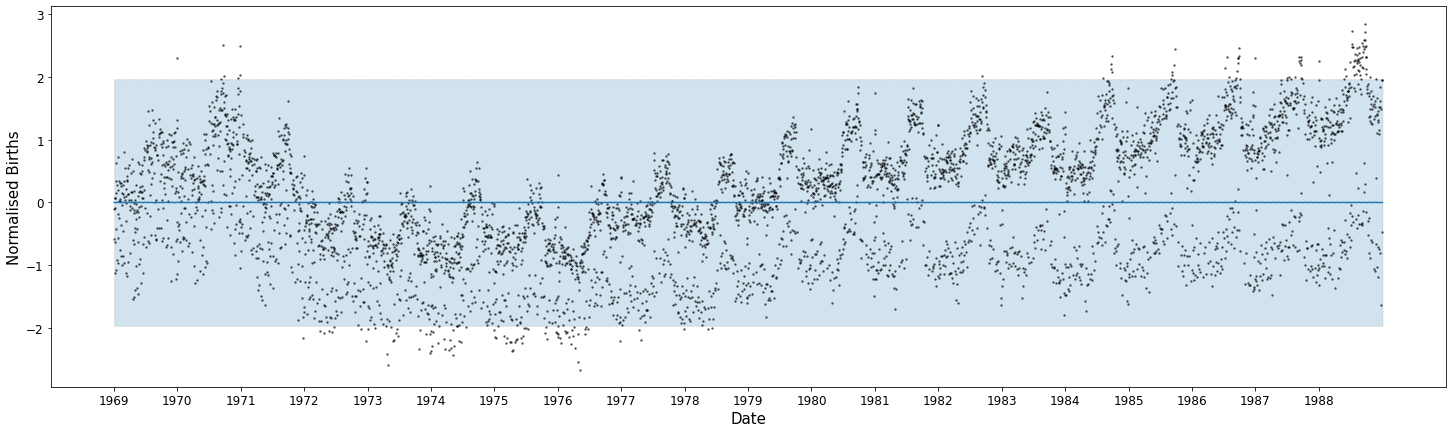

Test


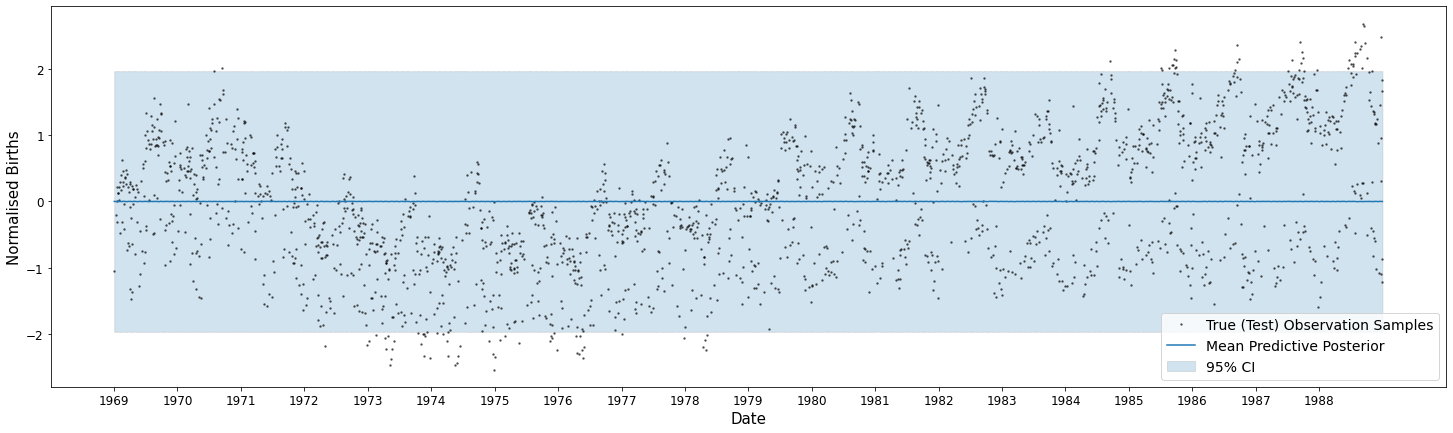

train ELBO, MSE, MAE:  -4268.255163258731 1.0000142999564259 0.8367677078751841
test ELBO, MSE, MAE:  -4316.459209017037 1.0321472492282249 0.8547034831996159
percentage out of CI (train, test):  3.5986700567181695 4.333941605839416
number out of CI (train, test):  184 95


--------------------------------------------------------
Train


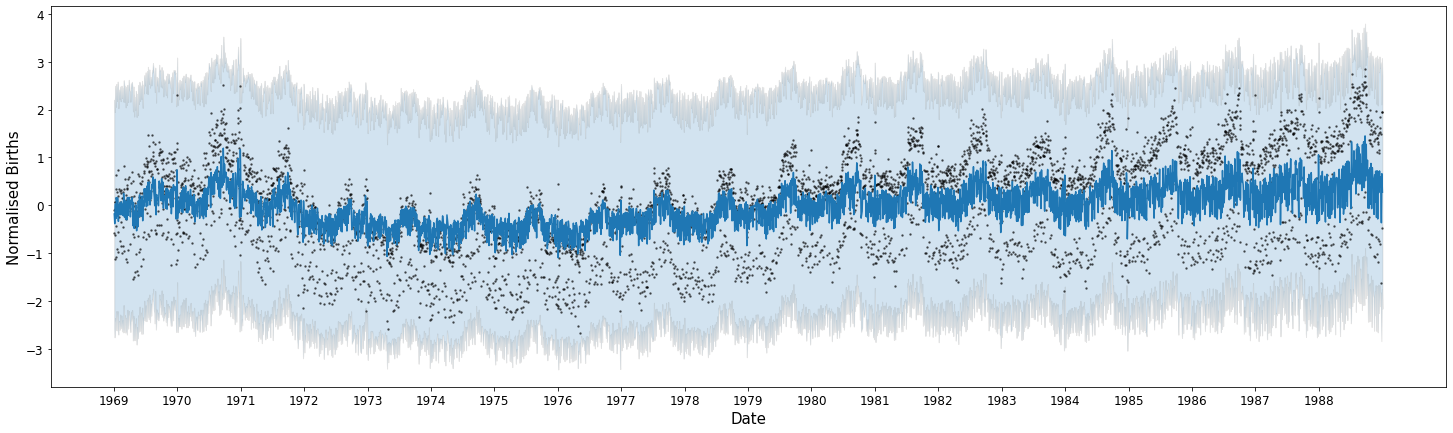

Test


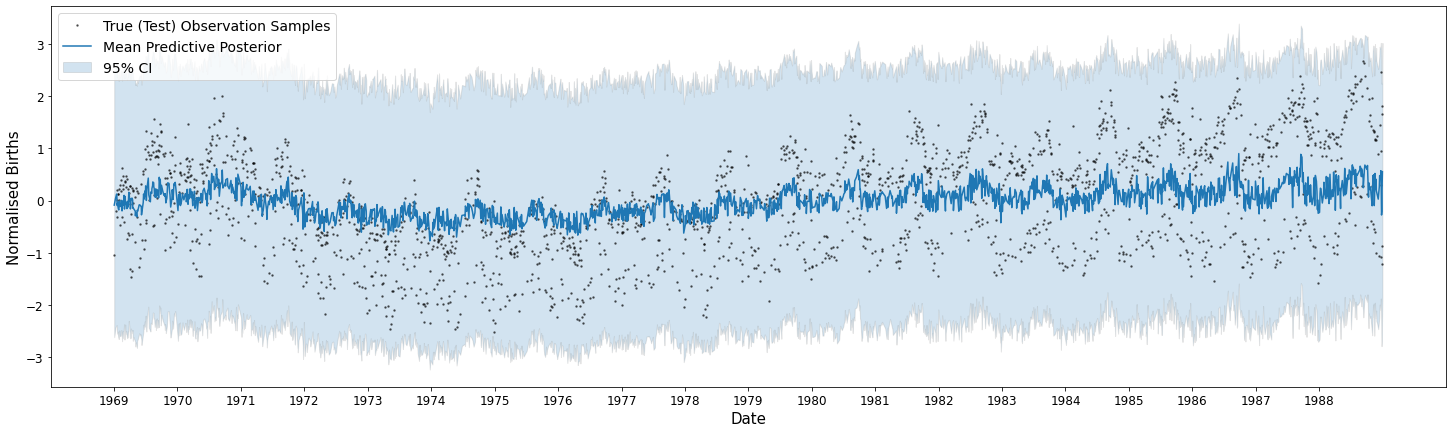

train ELBO, MSE, MAE:  -4611.7315635137675 0.42581773091185793 0.5478550288302803
test ELBO, MSE, MAE:  -5282.178792348514 0.7514680535505326 0.7326100627437452
percentage out of CI (train, test):  0.0 0.0
number out of CI (train, test):  0 0


--------------------------------------------------------
Train


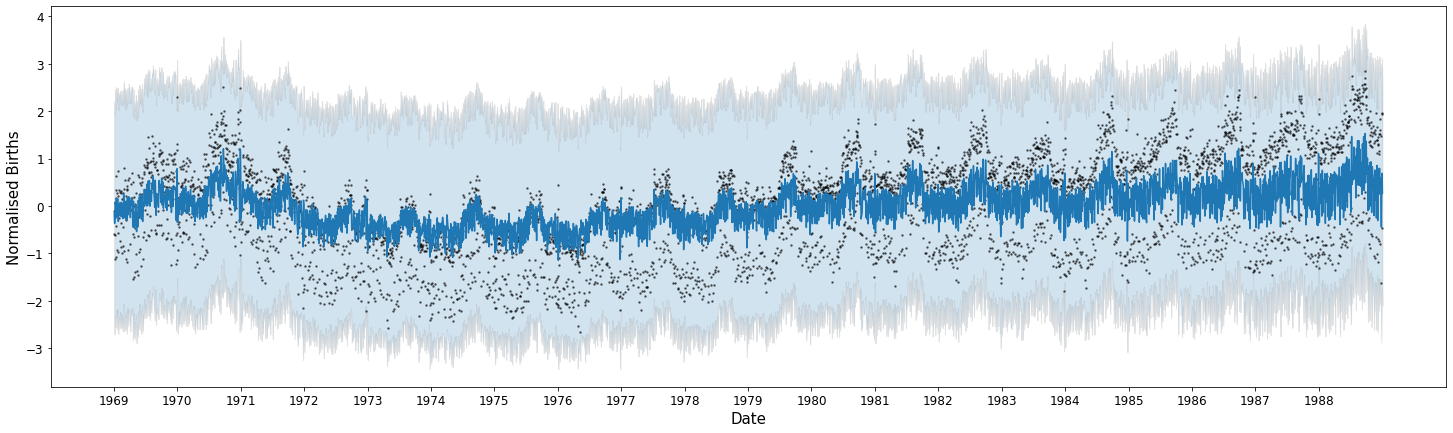

Test


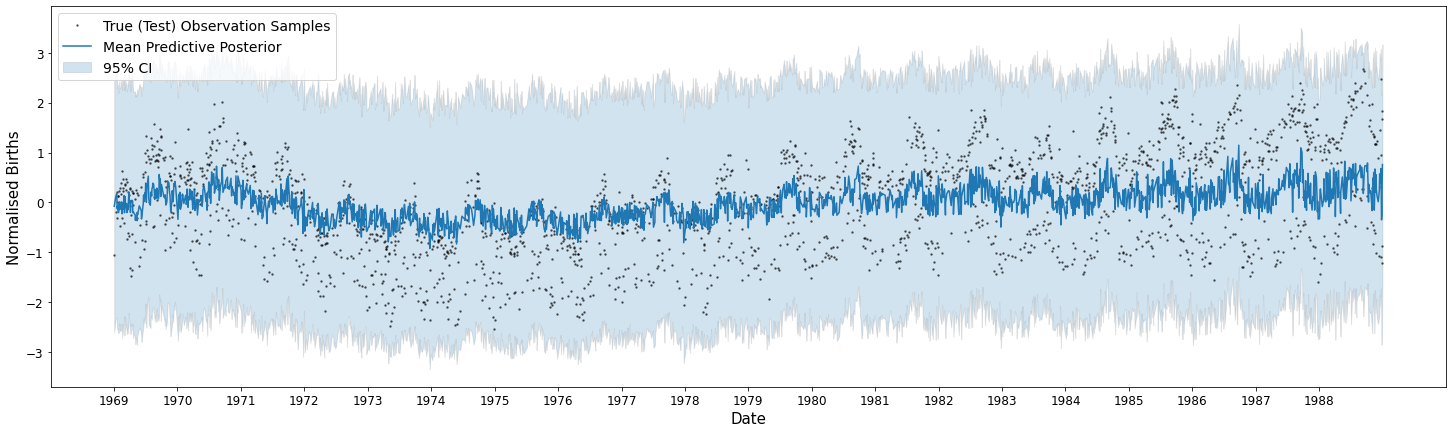

train ELBO, MSE, MAE:  -4515.645271992608 0.396352783735225 0.5254650704519637
test ELBO, MSE, MAE:  -5195.8858627038935 0.7179232997059299 0.7139534512755056
percentage out of CI (train, test):  0.0 0.0
number out of CI (train, test):  0 0


--------------------------------------------------------


In [4]:
# Kernel MODEL SELECTION
kernel_list = [gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25), gpflow.kernels.Periodic(gpflow.kernels.RBF()), gpflow.kernels.Matern32(), gpflow.kernels.RBF()]

M = 3000

for i in range(len(kernel_list)):
    print(kernel_list[i])

    kernel = kernel_list[i]

    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    set_trainable(model.likelihood.variance, False)

    if i in [0,1]:
        if i == 0:
            set_trainable(model.kernel.period, False)
        model.kernel.base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    else:
        model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    
    optimise_predict_model(model)
    print('--------------------------------------------------------')

The kernel with best performance: RBF. Although, Matern52 performs similar. BUT, the models seem to be overfitting. Maybe lower the epochs...

Now, we would carry out the sensitivity analysis done before but on the train test set.

Starting Values l:  1
Train


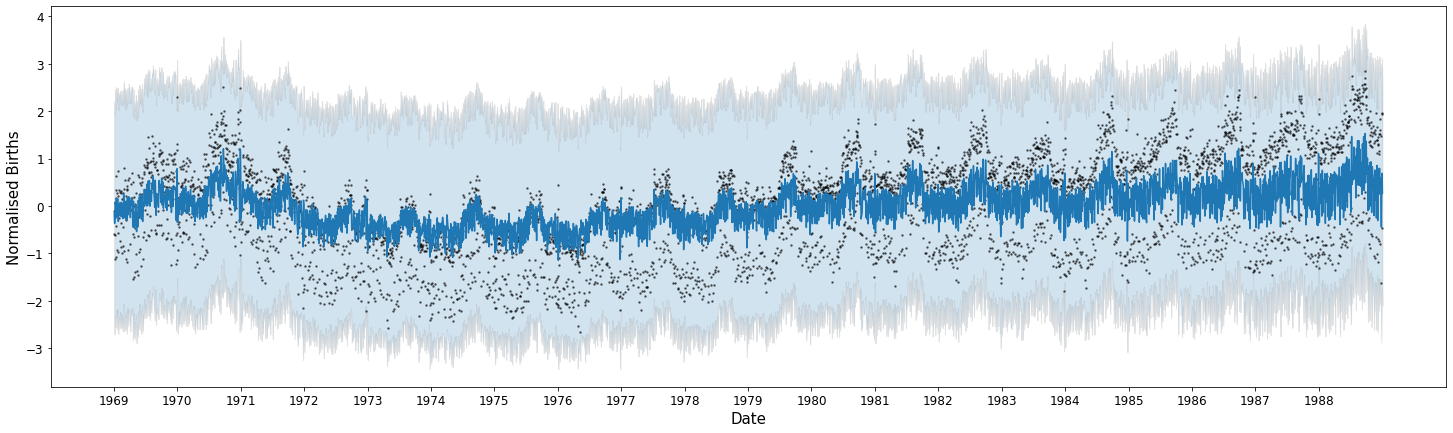

Test


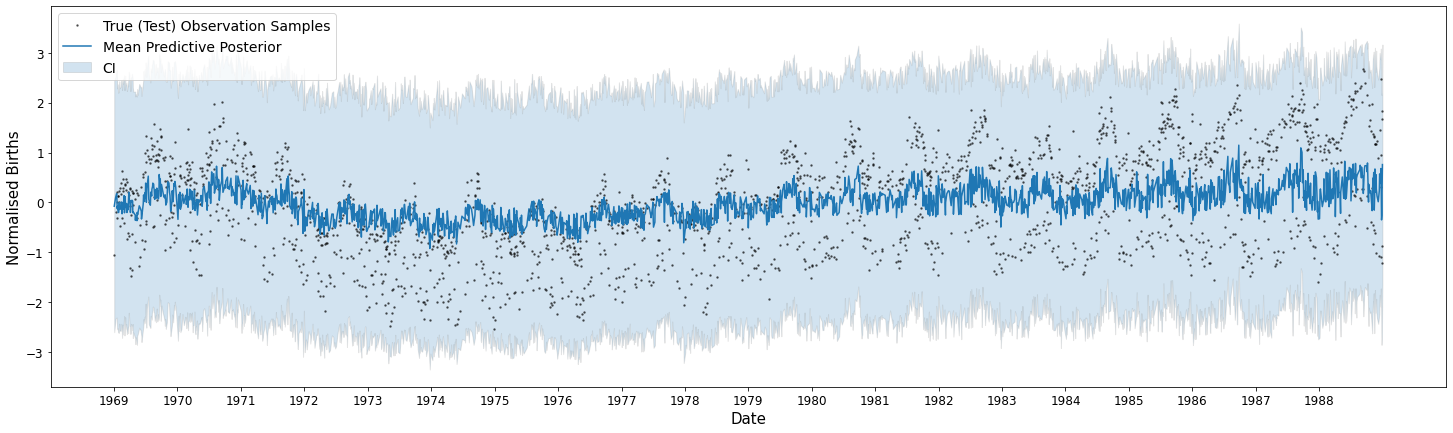

train ELBO, MSE, MAE:  -4515.645271992608 0.396352783735225 0.5254650704519637
test ELBO, MSE, MAE:  -5195.8858627038935 0.7179232997059299 0.7139534512755056
percentage out of CI (train, test):  0.0 0.0
number out of CI (train, test):  0 0


--------------------------------------------------------
Starting Values l:  7
Train


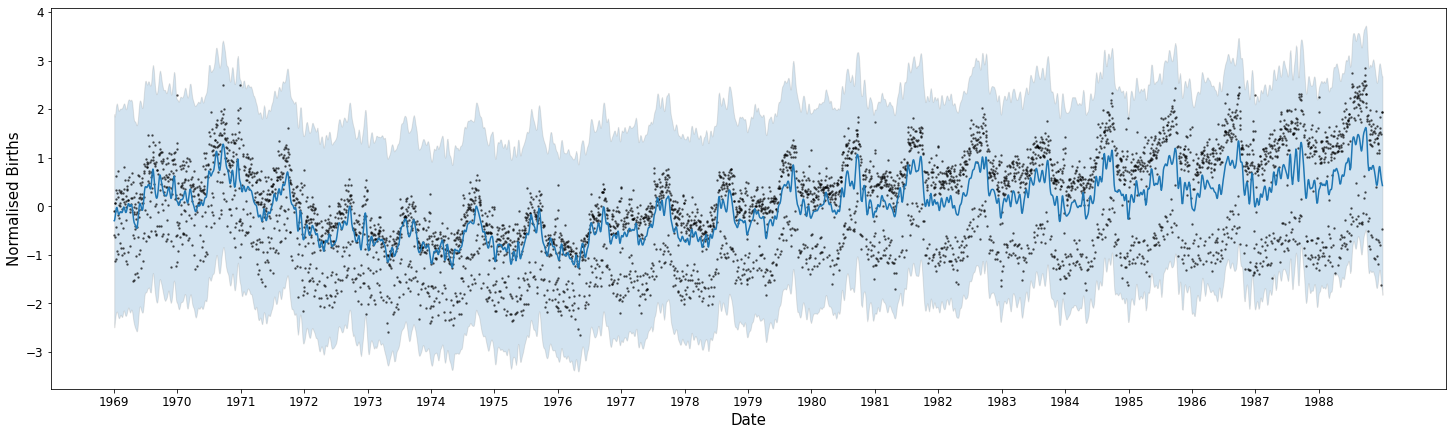

Test


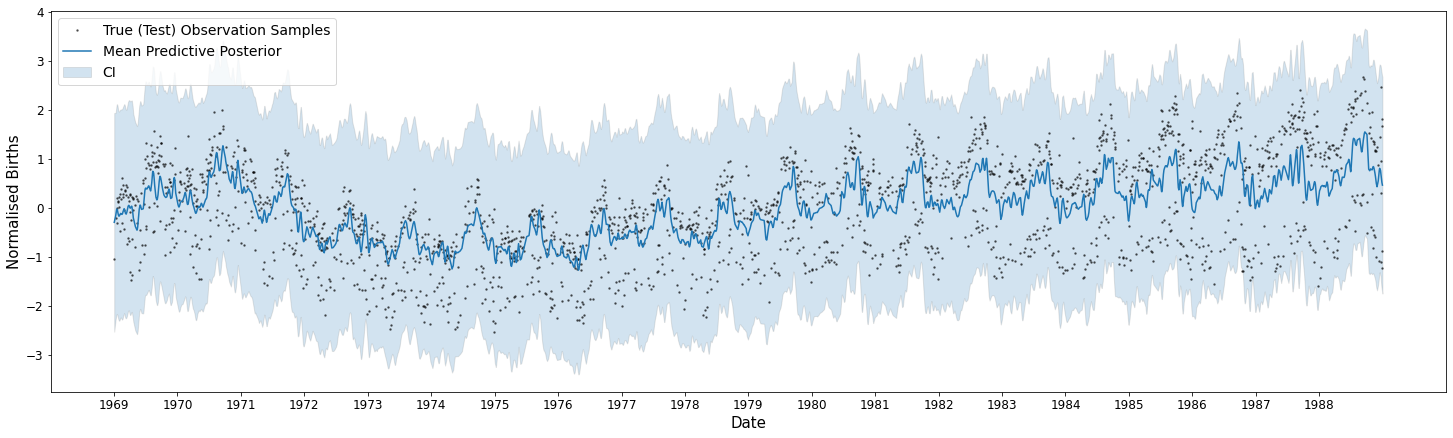

train ELBO, MSE, MAE:  -4128.6123126994935 0.5261769692440849 0.6090785346318901
test ELBO, MSE, MAE:  -4360.747462136867 0.6604616462750367 0.6846468713542824
percentage out of CI (train, test):  0.03911597887737141 0.04562043795620438
number out of CI (train, test):  2 1


--------------------------------------------------------
Starting Values l:  30
Train


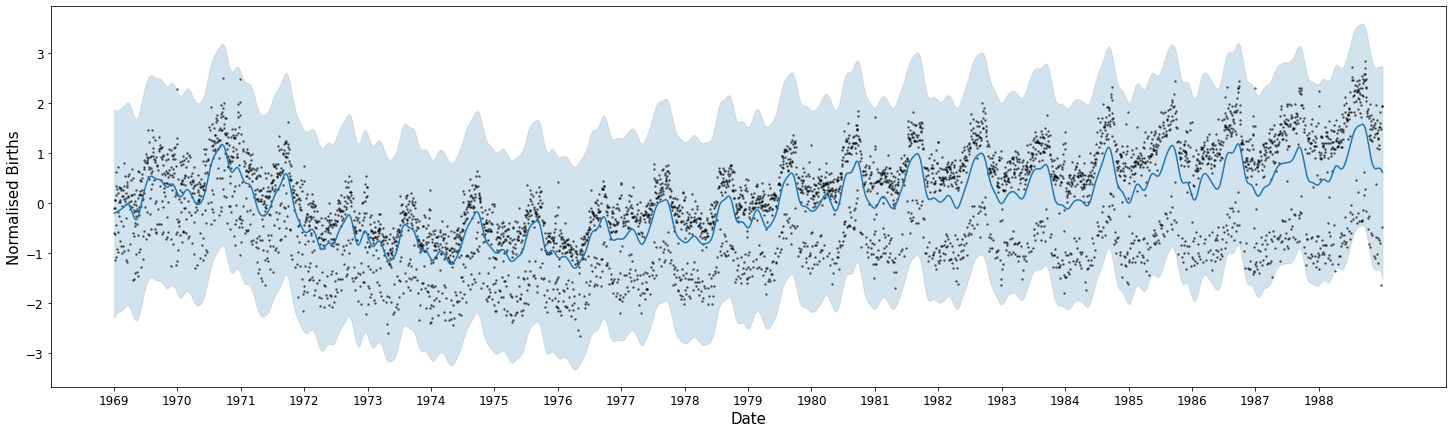

Test


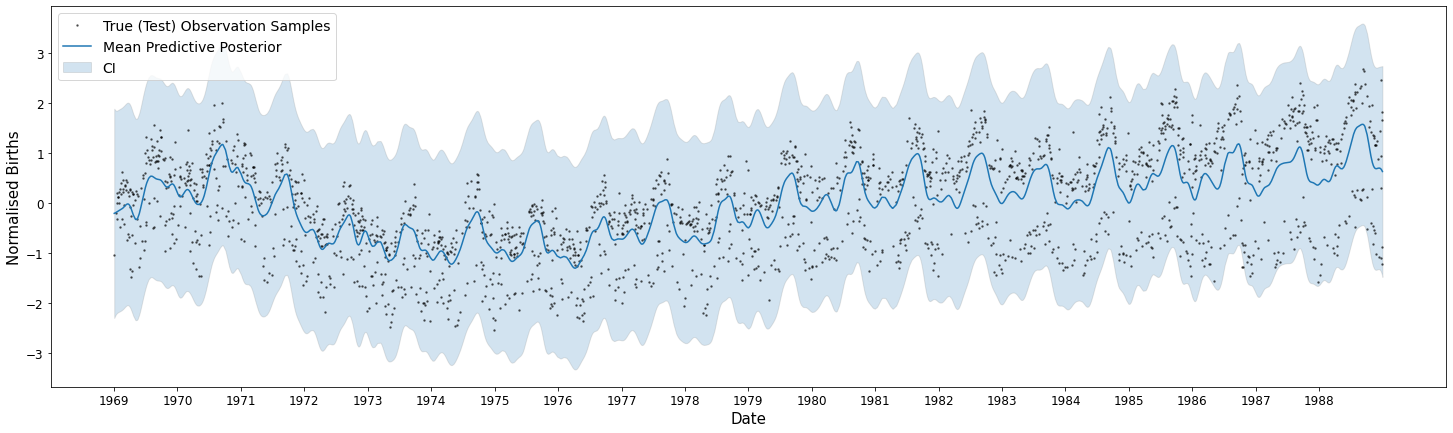

train ELBO, MSE, MAE:  -3837.0378414642246 0.5438587881799065 0.622446421741928
test ELBO, MSE, MAE:  -3914.5852976641063 0.5930950698815468 0.6490741667317758
percentage out of CI (train, test):  0.07823195775474281 0.09124087591240876
number out of CI (train, test):  4 2


--------------------------------------------------------


In [14]:
starting_values_l = [1, 7, 30]
M = 3000

for l in starting_values_l:
    print('Starting Values l: ', l)
    kernel = gpflow.kernels.RBF(lengthscales = l, variance = 1)
    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    set_trainable(model.likelihood.variance, False)
    
    model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
    model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

    optimise_predict_model(model)
    print('--------------------------------------------------------')

Starting Values v:  0.3
Train


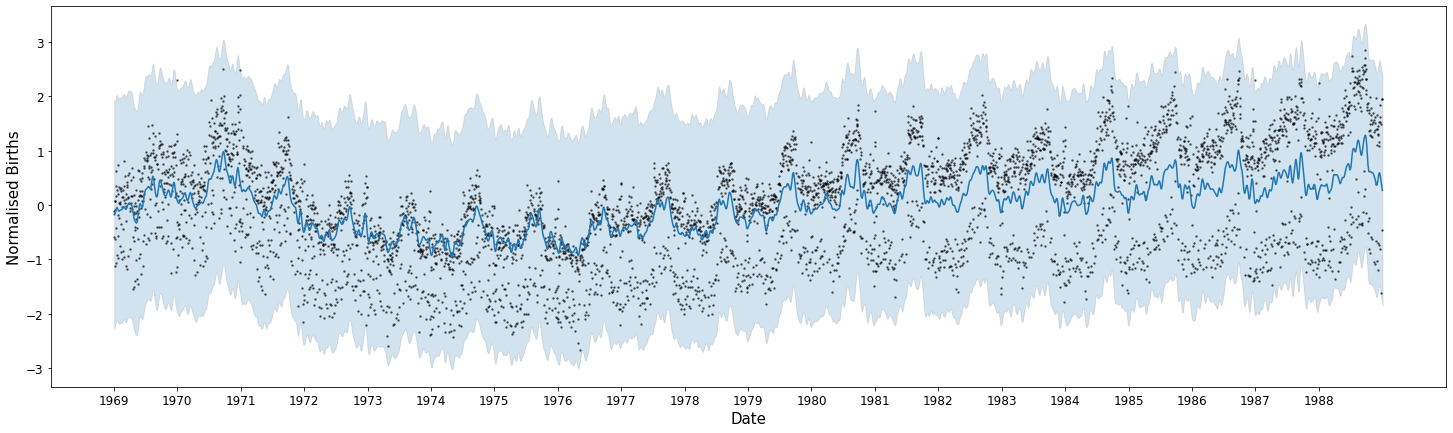

Test


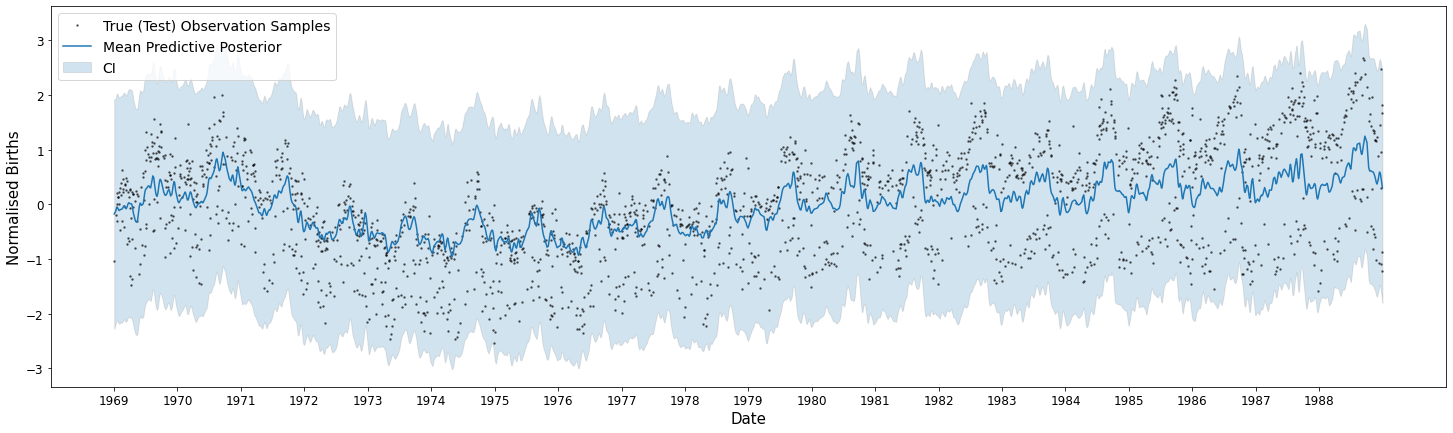

train ELBO, MSE, MAE:  -4029.580378771404 0.5789619137775043 0.6383912705267302
test ELBO, MSE, MAE:  -4184.675643871146 0.6743847429096 0.692301850112483
percentage out of CI (train, test):  0.058673968316057104 0.0
number out of CI (train, test):  3 0


--------------------------------------------------------
Starting Values v:  0.5
Train


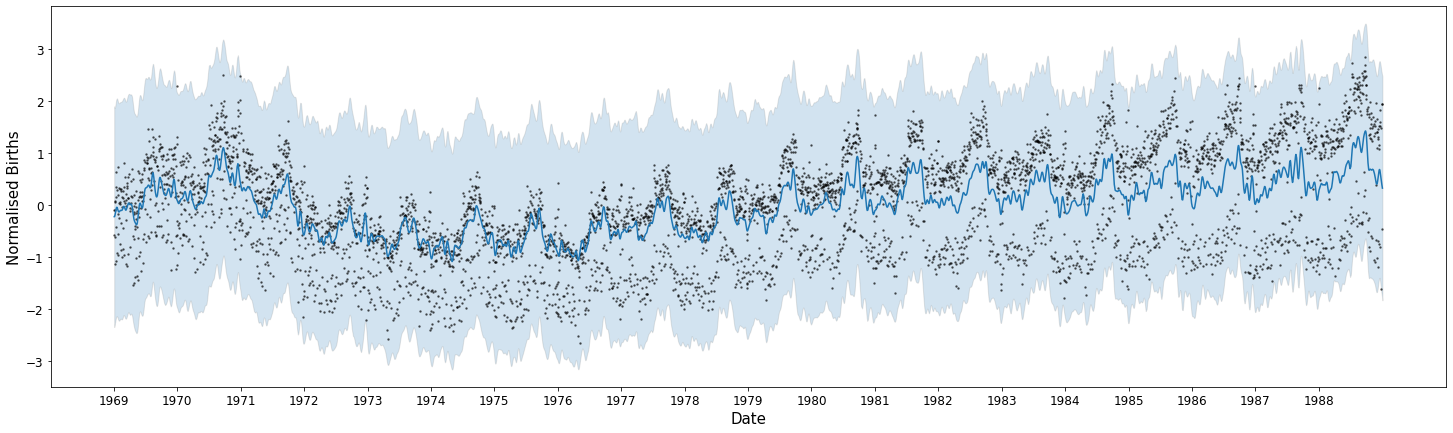

Test


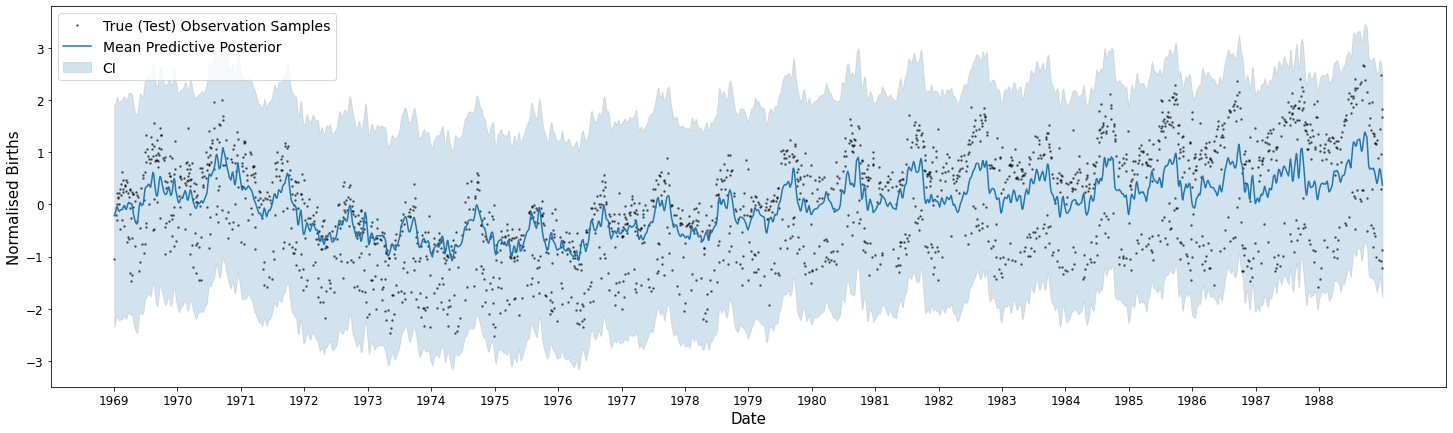

train ELBO, MSE, MAE:  -4044.0971952336886 0.5526730272119685 0.6238960920834483
test ELBO, MSE, MAE:  -4224.624796848641 0.6611402810213969 0.6847919406713119
percentage out of CI (train, test):  0.03911597887737141 0.0
number out of CI (train, test):  2 0


--------------------------------------------------------
Starting Values v:  1
Train


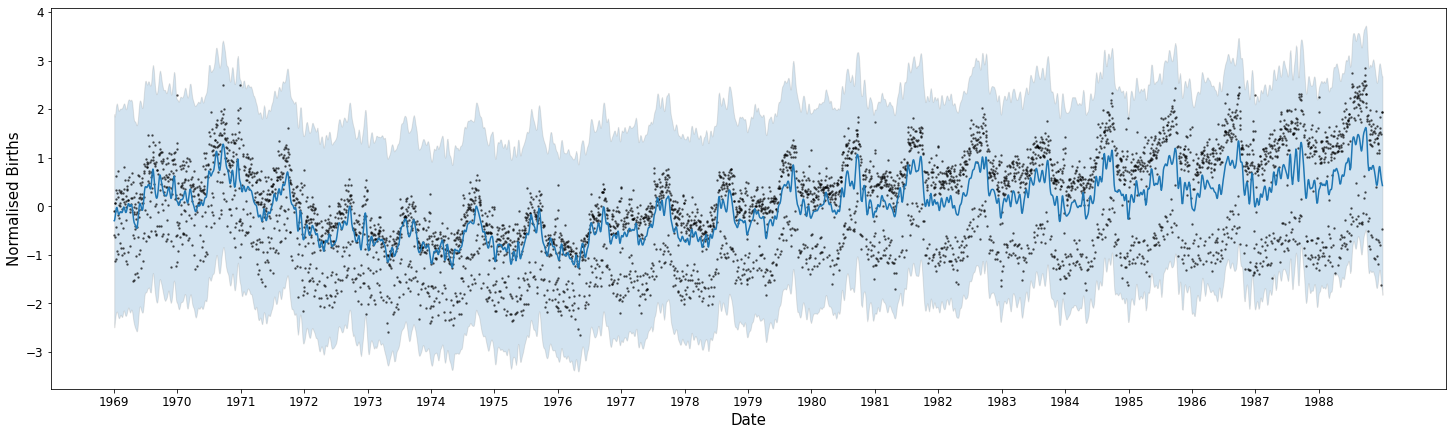

Test


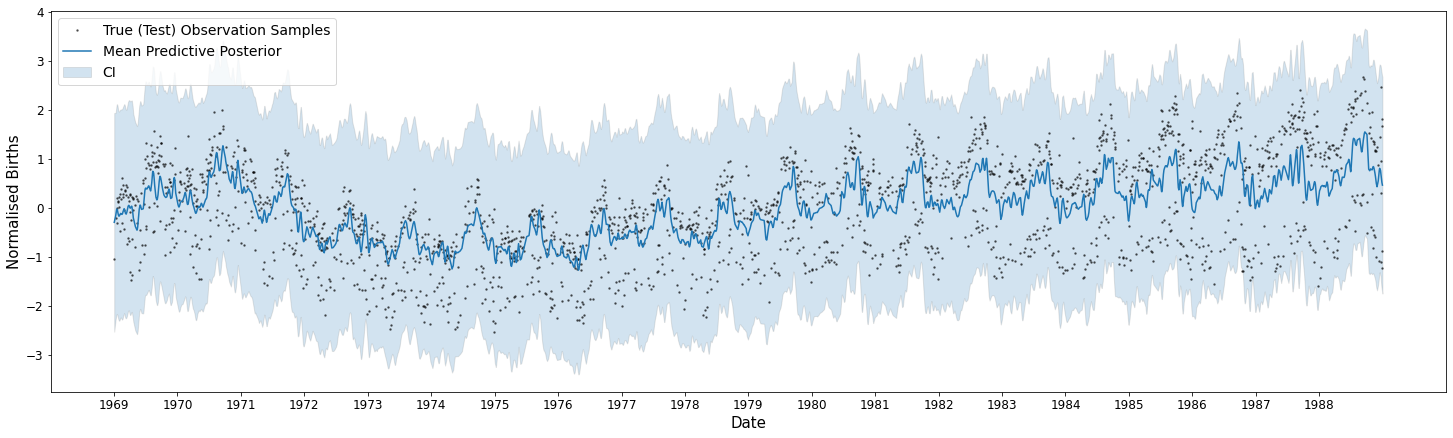

train ELBO, MSE, MAE:  -4128.6123126994935 0.5261769692440849 0.6090785346318901
test ELBO, MSE, MAE:  -4360.747462136867 0.6604616462750367 0.6846468713542824
percentage out of CI (train, test):  0.03911597887737141 0.04562043795620438
number out of CI (train, test):  2 1


--------------------------------------------------------
Starting Values v:  2
Train


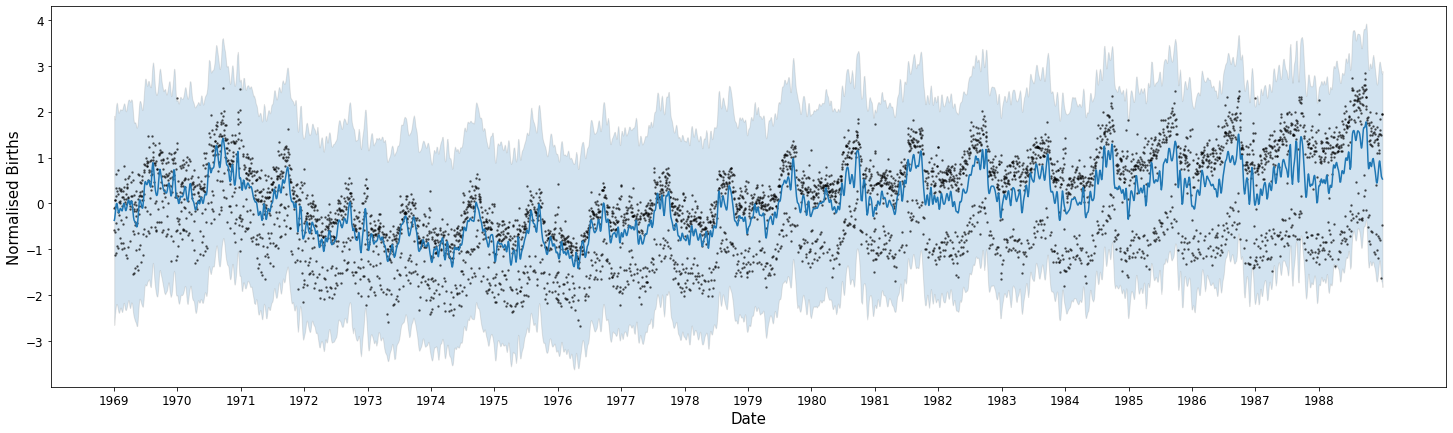

Test


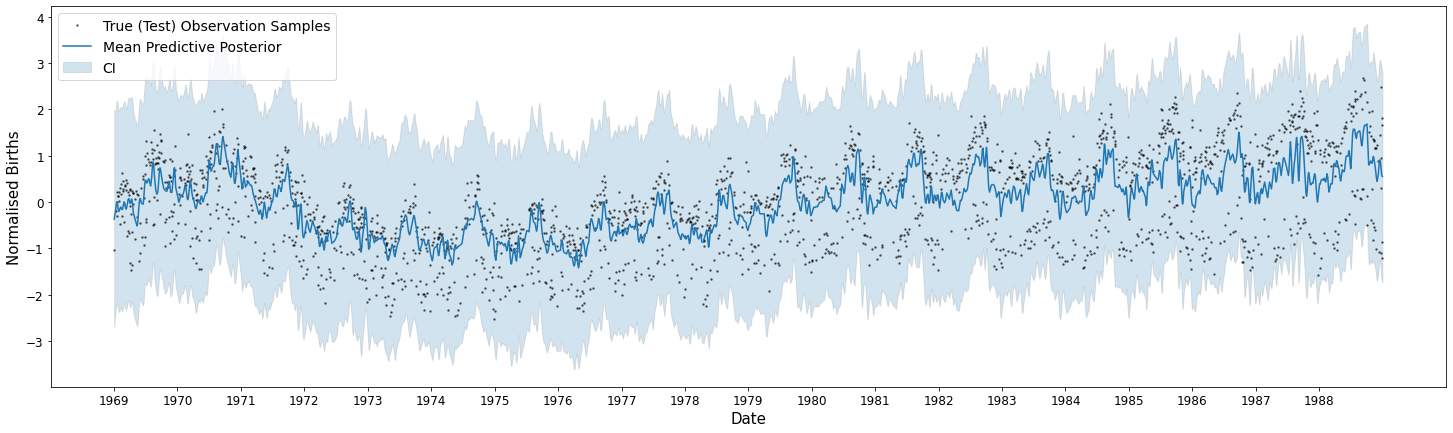

train ELBO, MSE, MAE:  -4300.526264798284 0.5124290881916865 0.6005988732619149
test ELBO, MSE, MAE:  -4596.36301695699 0.6776880386739592 0.6931502509778712
percentage out of CI (train, test):  0.058673968316057104 0.04562043795620438
number out of CI (train, test):  3 1


--------------------------------------------------------


In [15]:
starting_values_v = [0.3, 0.5, 1, 2]
M = 3000

for v in starting_values_v:
    print('Starting Values v: ', v)
    kernel = gpflow.kernels.RBF(lengthscales = 7, variance = v)
    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    set_trainable(model.likelihood.variance, False)
    
    model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
    model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

    optimise_predict_model(model)
    print('--------------------------------------------------------')

______________________________________
____________________________________

Plots for write up

Train


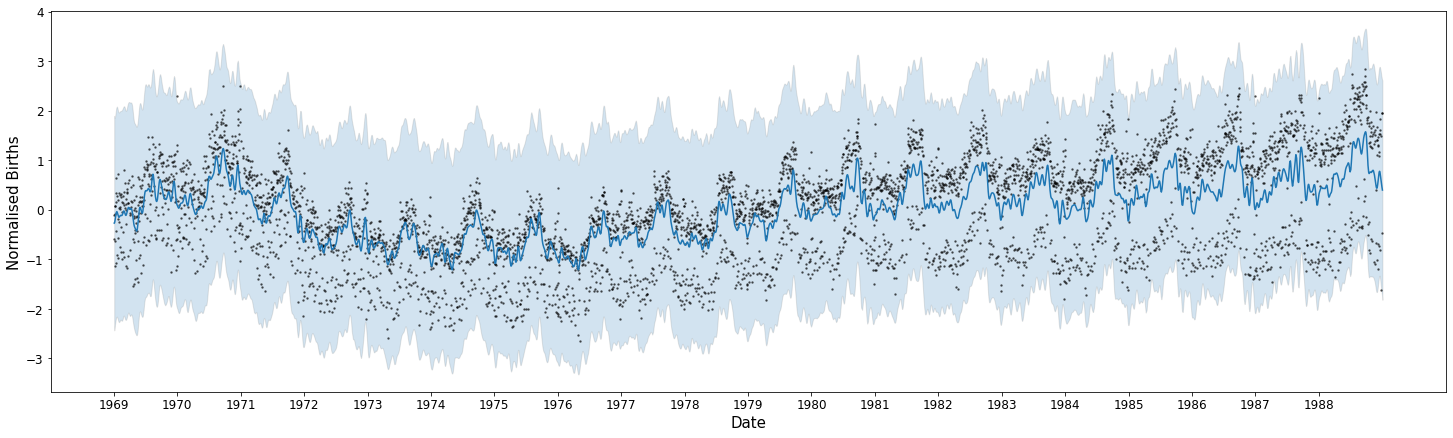

Test


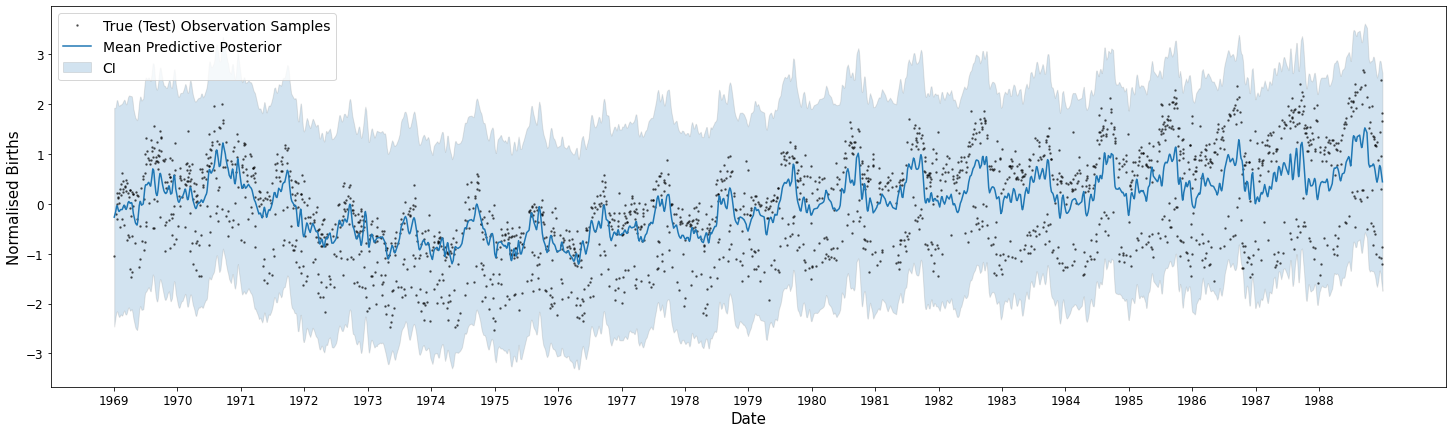

train ELBO, MSE, MAE:  -4077.768755572649 0.5332415894653965 0.6132952169187124
test ELBO, MSE, MAE:  -4282.099166124777 0.6534530998420675 0.6809880774483107
percentage out of CI (train, test):  0.03911597887737141 0.04562043795620438
number out of CI (train, test):  2 1


In [11]:
M = 3000
kernel = gpflow.kernels.RBF(lengthscales = 7, variance = 1)
Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
set_trainable(model.likelihood.variance, False)

model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

optimise_predict_model(model, epochs=100)

Train


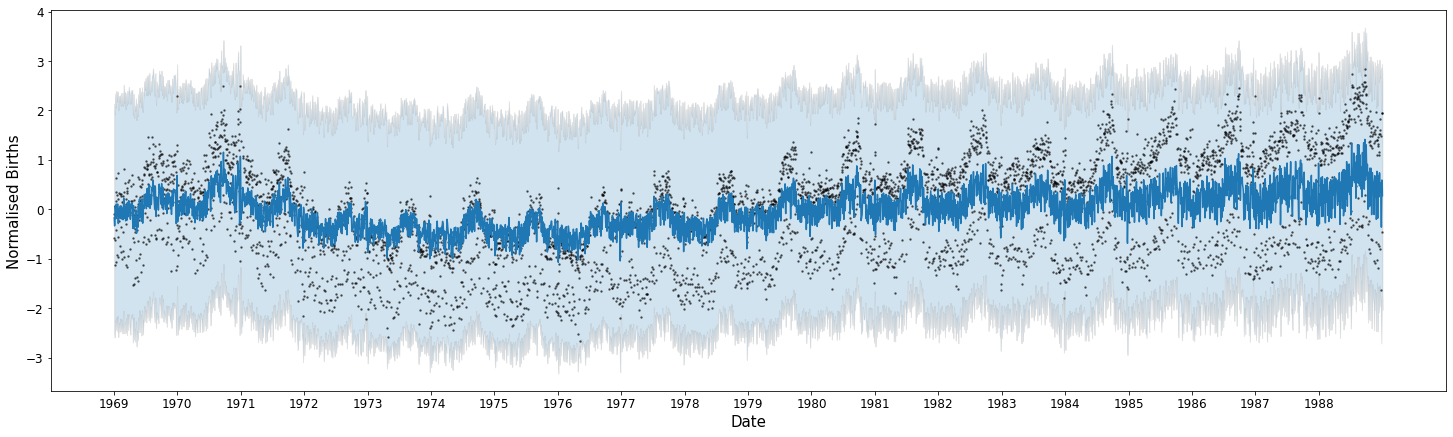

Test


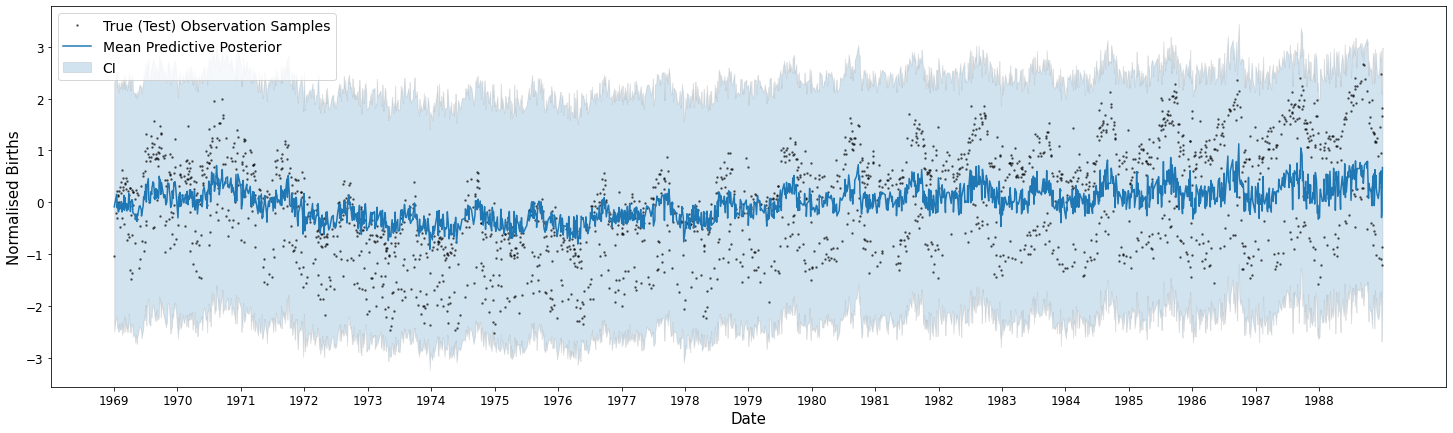

train ELBO, MSE, MAE:  -4397.234390735747 0.44022506779884163 0.5542205708881602
test ELBO, MSE, MAE:  -4961.611368611083 0.724807641976227 0.7183925638370942
percentage out of CI (train, test):  0.0 0.0
number out of CI (train, test):  0 0


In [12]:
M = 3000
kernel = gpflow.kernels.RBF(lengthscales = 1, variance = 1)
Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
set_trainable(model.likelihood.variance, False)

model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

optimise_predict_model(model, epochs=100)